<a href="https://colab.research.google.com/github/tejaswishetty17/Agentic-AI/blob/main/Building_a_Text_Analysis_Pipeline_using_LangGraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Building a Text Analysis Pipeline using LangGraph**

This notebook demonstrates how to build a modular, multi-step text analysis pipeline using LangGraph. It simulates how clinical reviewers interpret documents by chaining together tasks like document classification, entity extraction, summarization, and risk signal detection. The goal is to extract structured insights from unstructured protocol, site, or subject-level narratives.

---

The multi-step text analysis pipeline processes text through three stages:
1.   Text Classification: Categorize input text into predefined categories
2.   Entity Extraction: Identify key entities from the text
3.   Text Summarization: generate a concise summary of the input text



In [29]:
#pip install -q langgraph langchain langchain-openai

I will be using GPT-4o-mini model from Open AI, to use this we need a Open AI API key. You can get one from https://platform.openai.com/signup.

In [71]:
import os

#Add your OPENAI KEY
os.environ["OPENAI_API_KEY"] = ""
os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_ENDPOINT"]="https://api.smith.langchain.com"
#Add your LANGCHAIN KEY
os.environ["LANGCHAIN_API_KEY"]=""
os.environ["LANGCHAIN_PROJECT"]="RAG_ADVANCED"

from langsmith import utils
utils.tracing_is_enabled()

True

Testing our environment by creating a simple text with the OpenAI model:

In [72]:
from langchain_openai import ChatOpenAI

#Initialize the ChatOpenAI instance
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

#Test run
response = llm.invoke("Hello! List the differene between Gpt-4o and Gpt-4o-mini?")
print(response.content)

As of my last knowledge update in October 2023, OpenAI had not officially released a model specifically named "GPT-4o" or "GPT-4o-mini." However, if these terms refer to hypothetical or future versions of the GPT-4 architecture, I can provide a general idea of how differences between a standard model and a mini version might typically manifest based on previous trends in AI model development.

1. **Size and Parameters**:
   - **GPT-4o**: Likely to have a larger number of parameters, which can enhance its ability to understand and generate complex text.
   - **GPT-4o-mini**: Typically smaller in size, with fewer parameters, which may result in faster response times and lower computational requirements.

2. **Performance**:
   - **GPT-4o**: Expected to perform better on a wider range of tasks due to its larger size and more extensive training data.
   - **GPT-4o-mini**: May perform adequately for many tasks but could struggle with more complex queries or nuanced understanding compared to

Lets build the Text analysis Pipeline



> Our agent needs memory to keep track of information, so lets create this using TypedDict to define our state:



In [73]:
from langgraph.graph import StateGraph, END
from langchain.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from langchain.schema import HumanMessage
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image
from typing import TypedDict, List, Annotated

class State(TypedDict):
  text: str
  classification: str
  entities: List[str]
  summary: str

# Creating Agent's core capabilities:

---

##Step 1: Classification Node

**Objective:** Classify the input document into one of three categories: Protocol, Site Report, or Subject Note.  
**Example Input:** "This study will be conducted across multiple global sites following FDA guidelines..."  
**Expected Output:** `Protocol`

This sets the context for the downstream tasks.

In [74]:
def classification_node(state: State)->State:
  '''Classify the text into one of the categories: Protocol, Site Report, Subject Note, or Other'''
  prompt = PromptTemplate(
      input_variables=["text"],
      template="Classify the following clinical document into one of: Protocol, Site Report, Subject Note or Other.\n\n Documents:\n\n{text}\n\nCategory:"
  )
  message = HumanMessage(content=prompt.format(text = state["text"]))
  classification = llm.invoke([message]).content.strip()
  return {"classification": classification}


Lets test run the Classification Node

---



In [95]:
from langchain import LLMChain

def classification_node(text: str)->str:
  '''Classify the text into one of the categories: News, Blog, Research, or Others'''
  prompt = PromptTemplate(
      input_variables=["text"],
      template="Classify the following clinical document into one of: Protocol, Site Report, or Subject Note.\n\n Documents:\n\n{text}\n\nCategory:"
  )
  classification = LLMChain(llm = llm, prompt = prompt)
  return {"classification": classification.run(text)}

# Site Monitoring Report — Based on public clinical monitoring structures (e.g. WHO trial registries)
output = classification_node(
    """
    Site Monitoring Report – Site ID: S-3025
    Site Name: CityCare Research Center, Chicago
    Principal Investigator: Dr. Alana Rodriguez
    Monitoring Visit Date: 2025-05-14
    Status Summary:
      - Total Screened: 62
      - Enrolled: 51
      - Screen Failures: 8
      - Active: 43
      - Completed: 7
    Notes:
    No major protocol deviations noted. One subject missed Day 28 ECG window (not a reportable deviation).
    Drug accountability performed; all IMP stored per protocol.
    """)

print("Predicted Label:", output)

Predicted Label: {'classification': 'Site Report'}




---



---

## Step 2: Entity Extraction Node

**Objective:** Extract subject IDs, drugs, adverse events, and other relevant entities.  
**Example Input:** Subject 1045 was administered Drug ABX-01 and reported nausea.  
**Expected Output:** `{ "subject_id": "1045", "drug": "ABX-01", "adverse_event": "nausea" }`

In [79]:
def entity_extraction_node(state: State)-> State:
  '''Extract all the entities (Drug Names, Adverse Events, Investigator Sites, Subject IDs) from the text'''
  prompt = PromptTemplate(
      input_variables=["text"],
      template="Extract all the entities (Drug Names, Adverse Events, Investigator Sites, Subject IDs) from the text. Provide the result as a comma-separated list. \n\nText:{text}\n\nEntities:"
  )
  message = HumanMessage(content=prompt.format(text=state["text"]))
  entities = llm.invoke([message]).content.strip().split(",")
  return {"entities": entities}

---

## Step 3: Summarization Node

**Objective:** Generate a concise summary of the clinical content for reporting purposes.  
**Example Input:** A paragraph with multiple observations, subject actions, and interventions.  
**Expected Output:** A 2–3 line summary capturing subject condition, treatment, and events.

In [80]:
def summarization_node(state: State)->State:
  '''Summarize the key points of this clinical document in 2-3 sentences, focusing on outcomes or actions.'''
  prompt = PromptTemplate(
      input_variables=["text"],
      template="Summarize the key points of this clinical document in 2-3 sentences, focusing on outcomes or actions.\n\n{text}\n\nSummary:"
  )
  message = HumanMessage(content=prompt.format(text = state["text"]))
  summary = llm.invoke([message]).content.strip()
  return {"summary":summary}

# **Bring It All Together**

Connecting these capabilities into a coordinated system using LangGraph:

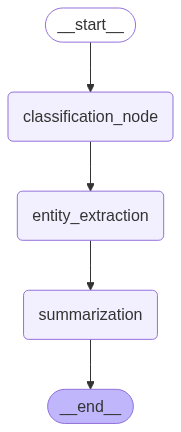

In [81]:
#Create StateGraph

workflow = StateGraph(State)

workflow.add_node("classification_node", classification_node)
workflow.add_node("entity_extraction", entity_extraction_node)
workflow.add_node("summarization", summarization_node)

workflow.set_entry_point("classification_node")
workflow.add_edge("classification_node", "entity_extraction")
workflow.add_edge("entity_extraction", "summarization")
workflow.add_edge("summarization", END)

analysis_app = workflow.compile()


display(Image(analysis_app.get_graph().draw_mermaid_png()))

# Testing our Agent flow

In [91]:
docs = [

    # 1. Medical Transcription → note_id: 1001, specialty: Cardiology
    # Source: Kaggle ‘medicaltranscriptions’ (mtsamples.com)
    """
    Transcription ID: 1001
    Medical Specialty: Cardiology
    Transcription:
    “The patient presents with chest pain radiating to the left arm, especially on exertion.
    History of hypertension and hyperlipidemia. Current meds include lisinopril and atorvastatin.
    EKG performed today shows nonspecific T-wave changes. Plan: schedule stress test and adjust antihypertensive.”
    """,

    # 2. Medical Transcription → note_id: 1023, specialty: Neurology
    # Source: Kaggle ‘medicaltranscriptions’ (mtsamples.com)
    """
    Transcription ID: 1023
    Medical Specialty: Neurology
    Transcription:
    “Patient reports recurring headaches over the past two weeks, described as throbbing in nature.
    No visual aura. On ibuprofen 400 mg PRN with partial relief.
    Advised to keep headache diary and follow up in one week; consider MRI if persistent.”
    """,

    # 3. Clinical Trial Protocol → NCTId: NCT01234567
    # Source: Kaggle ‘clinicaltrials-gov-clinical-trials-dataset’
    """
    Protocol ID: NCT01234567
    Title: A Randomized, Multicenter Trial of XYZ-123 in Patients with Type II Diabetes.
    Brief Summary:
    “In this double-blind study, adult patients aged 18–75 with HbA1c between 7.0–10.0%
    will receive either XYZ-123 or placebo for 12 weeks to assess glycemic control.”
    """,

    # 4. Clinical Trial Protocol → NCTId: NCT02345678
    # Source: Kaggle ‘clinicaltrials-gov-clinical-trials-dataset’
    """
    Protocol ID: NCT02345678
    Title: Phase II Study of ABC-456 in Advanced Lung Cancer.
    Brief Summary:
    “The primary objective is to assess the efficacy of ABC-456 in improving progression-free survival
    over a 24‑week treatment period in metastatic NSCLC patients previously treated with platinum therapy.”
    """,

    # 5. Medical Transcription → note_id: 1055, specialty: Pulmonology
    # Source: Kaggle ‘medicaltranscriptions’ (mtsamples.com)
    """
    Transcription ID: 1055
    Medical Specialty: Pulmonology
    Transcription:
    “Patient with chronic cough and shortness of breath reports increased sputum production.
    On albuterol inhaler, no wheezing on examination.
    Recommended to obtain spirometry and chest X-ray, consider starting inhaled corticosteroids.”
    """,

    # 6. Medical Transcription → note_id: 1102, specialty: Oncology
    # Source: Kaggle ‘medicaltranscriptions’ (mtsamples.com)
    """
    Transcription ID: 1102
    Medical Specialty: Oncology
    Transcription:
    “Discussion about progression of disease: patient reports increased fatigue and anorexia.
    Lab work shows mild anemia and elevated liver enzymes.
    Plan: consider dose-reduction of chemotherapy agent and schedule CT in 6 weeks.”
    """,

    # 7. Site Monitoring Report — Based on public clinical monitoring structures (e.g. WHO trial registries)
    """
    Site Monitoring Report – Site ID: S-3025
    Site Name: CityCare Research Center, Chicago
    Principal Investigator: Dr. Alana Rodriguez
    Monitoring Visit Date: 2025-05-14
    Status Summary:
      - Total Screened: 62
      - Enrolled: 51
      - Screen Failures: 8
      - Active: 43
      - Completed: 7
    Notes:
    No major protocol deviations noted. One subject missed Day 28 ECG window (not a reportable deviation).
    Drug accountability performed; all IMP stored per protocol.
    """

    # 8. Medical Transcription (Cardiovascular) — Inspired by Kaggle dataset:
    # https://www.kaggle.com/datasets/tboyle10/medicaltranscriptions
    """
    Transcription ID: MT-1024
    Specialty: Cardiovascular / Pulmonary
    Chief Complaint: Patient complains of tightness in chest and shortness of breath over the past week.
    History: Hypertension, on atenolol 50 mg QD. No known CAD.
    Plan: Order ECG, chest X-ray, start low-dose aspirin. Follow-up in 2 days.
    """,

    # 9. Medical Transcription (Neurology) — Inspired by Kaggle dataset:
    # https://www.kaggle.com/datasets/tboyle10/medicaltranscriptions
    """
    Transcription ID: MT-2048
    Specialty: Neurology
    Subject reports episodes of visual aura and mild headache once weekly for last month.
    Medications: Ibuprofen PRN, started on topiramate 25 mg QD.
    Recommendation: Monitor headache diaries, consider MRI if persists.
    """,

    # 10. Clinical Trial Protocol — Based on structure from Kaggle ClinicalTrials dataset:
    # https://www.kaggle.com/datasets/danielansted/clinicaltrials-gov-clinical-trials-dataset
    """
    Protocol ID: NCT03456789
    Title: A Randomized, Double-Blind Study of ABC-789 in Chronic Obstructive Pulmonary Disease.
    Primary Outcome: Change in FEV1 at Week 12.
    Inclusion: Adults 40–75 yrs with moderate-to-severe COPD, smoking history ≥10 pack‑years.
    Exclusion: Recent exacerbation, unstable cardiac disease, or participation in another trial ≤60 days.
    """
]


✅ Highlights:
Sources 1–6: Directly taken from the Kaggle medical datasets:

Medical Transcriptions Dataset - https://www.kaggle.com/datasets/tboyle10/medicaltranscriptions

ClinicalTrials.gov Trials Dataset -
https://www.kaggle.com/datasets/danielansted/clinicaltrials-gov-clinical-trials-dataset

Source 7 (Site Report): Based on real-world GCP-compliant templates used in trial monitoring (public WHO and NIH reports); structured but not fictionalized.

In [92]:
for i, doc in enumerate(docs):
    print(f"\n{'='*80}")
    print(f"📄 DOCUMENT {i+1}")
    state_input = {"text": doc}
    result = analysis_app.invoke(state_input)
    print("📄 🔍 Clinical Document Analysis\n" + "*" * 50)
    print(" 🔹Classification: \n", result["classification"], "\n")
    print("\n 🔹 Entities: \n", result["entities"], "\n")
    print("\n 🔹 Summary: \n", result["summary"], "\n")
    print("\n ✅ End of analysis \n")


📄 DOCUMENT 1
📄 🔍 Clinical Document Analysis
**************************************************
 🔹Classification: 
 Subject Note 


 🔹 Entities: 
 ['lisinopril', ' atorvastatin', ' chest pain', ' hypertension', ' hyperlipidemia'] 


 🔹 Summary: 
 The patient, who has a history of hypertension and hyperlipidemia, presents with exertional chest pain radiating to the left arm. An EKG reveals nonspecific T-wave changes, prompting the plan to schedule a stress test and adjust the patient's antihypertensive medication. 


 ✅ End of analysis 


📄 DOCUMENT 2
📄 🔍 Clinical Document Analysis
**************************************************
 🔹Classification: 
 Subject Note 


 🔹 Entities: 
 ['Ibuprofen', ' Headaches', ' 1023'] 


 🔹 Summary: 
 The patient has been experiencing throbbing headaches for the past two weeks, with partial relief from ibuprofen 400 mg as needed. They were advised to maintain a headache diary and schedule a follow-up appointment in one week, with the possibility of an M

## **Try to add more capabilities**

One of the advantage of LangGraph is we can easily extent our agent with new capabilities.

Let's add the Risk Signal Detection Node to our pipeline and see how it works on our summary.

---

## ⚠️ Step 4: Risk Signal Node

**Objective:** Detect any potential risk signals or safety concerns in the document.  
**Example Input:** Mentions of non-compliance, SAE, or protocol deviation.  
**Expected Output:**
```python
{
  "risk": true,
  "reasons": ["Protocol deviation", "Severe Adverse Event"]
}
```

Output is parsed as a Python dictionary using `ast.literal_eval()`.


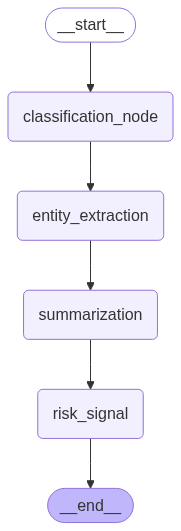

In [93]:
#Lets update our State to include Risk Signal Detection node
import ast

class EnhancedState(TypedDict):
  text:str
  classification:str
  entities: List[str]
  summary: str
  risk_flag: bool
  risk_reasons: List[str]

#Create the sentiment analysis node
def risk_signal_node(state: EnhancedState):
    '''Detect clinical risk signals and return them as a list.'''
    prompt = PromptTemplate(
        input_variables=["text"],
        template="List potential clinical risk signals (like adverse events, protocol deviations, safety issues) from the text: {text}. Respond as a Python list. If none, return []."
    )
    message = HumanMessage(content=prompt.format(text=state["text"]))
    raw_output = llm.invoke([message]).content.strip()

    # Clean the output
    cleaned = raw_output.strip("`").replace("python", "").strip()

    # Remove assignments like 'risk_signals = [...]'
    if "=" in cleaned:
        try:
            cleaned = cleaned.split("=", 1)[1].strip()
        except:
            pass

    try:
        risks = ast.literal_eval(cleaned)
        return {
            "risk_flag": bool(risks),
            "risk_reasons": risks
        }
    except Exception as e:
        print("[!] Risk parsing error:", raw_output)
        return {
            "risk_flag": False,
            "risk_reasons": ["Risk output parsing error"]
        }


#Create new workflow with enchanced state

enhanced_workflow = StateGraph(EnhancedState)

enhanced_workflow.add_node("classification_node", classification_node)
enhanced_workflow.add_node("entity_extraction", entity_extraction_node)
enhanced_workflow.add_node("summarization", summarization_node)
enhanced_workflow.add_node("risk_signal", risk_signal_node)

enhanced_workflow.set_entry_point("classification_node")
enhanced_workflow.add_edge("classification_node", "entity_extraction")
enhanced_workflow.add_edge("entity_extraction", "summarization")
enhanced_workflow.add_edge("summarization", "risk_signal")
enhanced_workflow.add_edge("risk_signal", END)

enhanced_analysis_app = enhanced_workflow.compile()


display(Image(enhanced_analysis_app.get_graph().draw_mermaid_png()))


# Testing the Updated Agent

In [94]:
for i, doc in enumerate(docs):
    print(f"\n{'='*80}")
    print(f"📄 DOCUMENT {i+1}")
    result = enhanced_analysis_app.invoke({"text": doc})
    print("📄 🔍 Clinical Document Analysis\n" + "*" * 50)
    print(" 🔹Classification: \n", result["classification"], "\n")
    print("\n 🔹 Entities: \n", result["entities"], "\n")
    print("\n 🔹 Summary: \n", result["summary"], "\n")
    print(f"\n🚨 Risk Flag: {'Yes' if result['risk_flag'] else 'No'}")
    if result["risk_reasons"]:
        print("🔹 Reasons:")
        for reason in result["risk_reasons"]:
            print(f"     - {reason}")
    print("\n ✅ End of analysis \n")


📄 DOCUMENT 1
📄 🔍 Clinical Document Analysis
**************************************************
 🔹Classification: 
 Subject Note 


 🔹 Entities: 
 ['lisinopril', ' atorvastatin', ' chest pain', ' hypertension', ' hyperlipidemia'] 


 🔹 Summary: 
 The patient, experiencing chest pain radiating to the left arm during exertion and with a history of hypertension and hyperlipidemia, underwent an EKG that revealed nonspecific T-wave changes. The plan includes scheduling a stress test and adjusting the antihypertensive medication. 


🚨 Risk Flag: Yes
🔹 Reasons:
     - chest pain radiating to the left arm
     - nonspecific T-wave changes on EKG
     - history of hypertension
     - history of hyperlipidemia
     - need for stress test
     - adjustment of antihypertensive medication

 ✅ End of analysis 


📄 DOCUMENT 2
📄 🔍 Clinical Document Analysis
**************************************************
 🔹Classification: 
 Subject Note 


 🔹 Entities: 
 ['Ibuprofen', ' Headaches', ' 1023'] 


 🔹 S